In [4]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def rgb_to_ycocg_r(img):
    R = img[:, :, 0].astype(np.int32)
    G = img[:, :, 1].astype(np.int32)
    B = img[:, :, 2].astype(np.int32)

    # Forward transform (YCoCg-R)
    Co = R - B
    t  = B + (Co >> 1)
    Cg = G - t
    Y  = t + (Cg >> 1)

    return Y, Co, Cg


def normalize_channel(channel):
    ch_min = channel.min()
    ch_max = channel.max()

    # Avoid division by zero
    if ch_max == ch_min:
        return np.zeros_like(channel, dtype=np.uint8)

    # Scale to 0–255
    norm = (channel - ch_min) * (255.0 / (ch_max - ch_min))
    return norm.astype(np.uint8)


def show_image(title, img, cmap=None):
    plt.figure(figsize=(5,5))
    plt.title(title)
    if cmap is not None:
        plt.imshow(img, cmap=cmap)
    else:
        plt.imshow(img)
    plt.axis("off")
    plt.show()


In [5]:
def false_color_co(Co):
    """Map Co to orange-blue color."""
    norm = normalize_channel(Co)
    rgb = np.zeros((norm.shape[0], norm.shape[1], 3), dtype=np.uint8)
    rgb[:, :, 0] = norm          # R
    rgb[:, :, 1] = 128           # fixed mid green
    rgb[:, :, 2] = 255 - norm    # B (complement)
    return rgb

def false_color_cg(Cg):
    """Map Cg to green-magenta color."""
    norm = normalize_channel(Cg)
    rgb = np.zeros((norm.shape[0], norm.shape[1], 3), dtype=np.uint8)
    rgb[:, :, 0] = 255 - norm    # R (complement)
    rgb[:, :, 1] = norm          # G
    rgb[:, :, 2] = 255 - norm    # B (magenta mix)
    return rgb

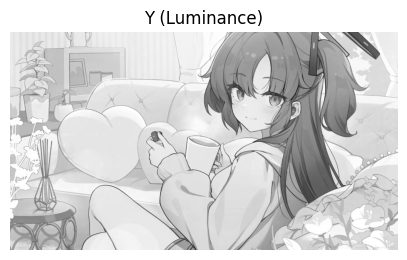

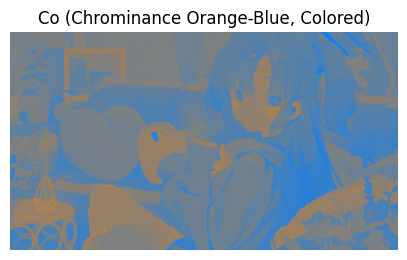

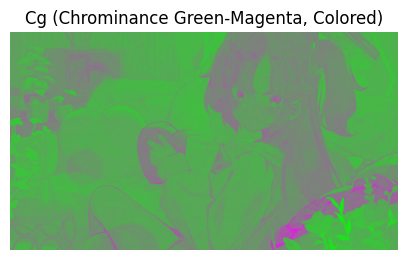

Berhasil disimpan: Y.png, Co.png, Cg.png


In [6]:
dir = "img/"
input_path = dir + "mybini.png"

img = Image.open(input_path).convert("RGB")
img_np = np.array(img)

Ye, Co, Cg = rgb_to_ycocg_r(img_np)

# Normalize grayscale (untuk tampilan asli)
Y_norm  = normalize_channel(Ye)
Co_norm = normalize_channel(Co)
Cg_norm = normalize_channel(Cg)

# False-color visualization
Co_color = false_color_co(Co)
Cg_color = false_color_cg(Cg)

# ===== SHOW IMAGES =====
show_image("Y (Luminance)", Y_norm, cmap='gray')
show_image("Co (Chrominance Orange-Blue, Colored)", Co_color)
show_image("Cg (Chrominance Green-Magenta, Colored)", Cg_color)

# ===== SAVE OUTPUT =====
Image.fromarray(Y_norm).save(dir + "Y.png")
Image.fromarray(Co_color).save(dir + "Co.png")
Image.fromarray(Cg_color).save(dir + "Cg.png")

print("Berhasil disimpan: Y.png, Co.png, Cg.png")